In [ ]:
import numpy as np
import pandas as pd
import cloudpickle
import matplotlib.pyplot as plt
import random
from pathlib import Path
import seaborn as sns
from scipy.stats import linregress
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import TransformerMixin

random_state = 42
np.random.seed(42)
random.seed(42)
sns.set_theme(font='Arial')
custom_palette = sns.color_palette("viridis", 2)

class RemCorr(TransformerMixin):
    def __init__(self, threshold=None, cols_to_keep=None):
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep

    def __repr__(self):
        return f"RemCorr(threshold={self.threshold})"

    def fit(self, X, y=None):
        """
        Response by User: @Synergix to Stack Question:
        https://stackoverflow.com/a/61938339/19293517

        Objective:
            Remove collinear features in a dataframe with a correlation coefficient
            greater than the threshold. Removing collinear features can help a model
            to generalize and improves the interpretability of the model.

        Inputs:
            x: features dataframe
            threshold: features with correlations greater than this value are removed

        Output:
            dataframe that contains only the non-highly-collinear features
        """

        # Calculate the correlation matrix
        x = pd.DataFrame(data=X)
        corr_matrix = x.corr()
        iters = range(len(corr_matrix.columns) - 1)
        drop_cols = []

        # Iterate through the correlation matrix and compare correlations
        for i in iters:
            for j in range(i + 1):
                item = corr_matrix.iloc[j : (j + 1), (i + 1) : (i + 2)]
                col = item.columns
                row = item.index
                val = abs(item.values)

                # If correlation exceeds the threshold
                if val >= self.threshold:
                    # Print the correlated features and the correlation value
                    # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                    drop_cols.append(col.values[0])

        # Drop one of each pair of correlated columns
        drops = set(drop_cols)
        x = x.drop(columns=drops)
        self.cols_to_keep = x.columns
        return self

    def transform(self, X: np.ndarray, y=None):
        return X[:, self.cols_to_keep]

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_params(self, deep=True):
        return {
            key: value
            for key, value in self.__dict__.items()
            if not key.startswith("_")
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def get_feature_names_out(self):
        return self.cols_to_keep

def calc_ee(ddG_er):
    true_er = np.exp((ddG_er / (0.000239 * (0 + 273.15) * (8.314))))
    true_ee = (true_er - 1) / (true_er + 1) * 100
    return true_ee

def eval_ext(
    estimator: Pipeline,
    _X_train: pd.DataFrame,
    _ev_X: pd.DataFrame,
    _Y_train: pd.DataFrame,
    _ev_Y: pd.DataFrame,
    verbose: bool,
    ):
    # Predicts and reshapes to make it usable
    pred_Xtrain = estimator.predict(_X_train)

    # Metrics for Train Data in Model
    train_R2 = r2_score(y_true=_Y_train, y_pred=pred_Xtrain)
    train_mae = mean_absolute_error(y_true=_Y_train, y_pred=pred_Xtrain)
    train_slope, train_intercept, train_rvalue, train_pvalue, train_stderr = (
        linregress(_Y_train, pred_Xtrain)
    )
    train_spearmanr2 = train_rvalue**2
    if verbose:
        print(f'''Train:
$R^2$={train_R2:.3f}
y={train_slope:.3f}x+{train_intercept:.3f}
$r^2$={train_spearmanr2:.3f}
MAE={train_mae:.3f}
''')
    pred_ev_Y = estimator.predict(_ev_X)

    pred_ee = calc_ee(pred_ev_Y)
    obs_ee = calc_ee(_ev_Y)

    ext_df = pd.DataFrame({
        r"Predicted $\%ee$":pred_ee,
        r"Observed $\%ee$":obs_ee,
        }, index=_ev_X.index)
    
    return ext_df

def create_ee_df(res_df: pd.DataFrame, title: str, plot: bool, color_palette):

    #Fixes index formatting
    res_df.index = [" ".join(''.join(x.split("Ex_")).split("_")) for x in res_df.index]
    
    #Creates usable dataframe for predicted vs observed
    df_long = res_df.reset_index().melt(id_vars=['index'], var_name='type',
                                        value_name='value')
    
    #Renames melted dataframe for Seaborn plotting
    df_long.columns = ["Alkenes", "", r"$\%ee$"]

    #Isolates areas referring to observed ddG MAE and sets it to np.nan instead
    isolate_df = df_long.loc[df_long[""] == r"Observed $\%ee$"]

    if plot:
        #Creates CatPlot and formats it as desired
        g = sns.catplot(
            data=df_long,
            x='Alkenes',
            y=r"$\%ee$",
            hue="",
            palette=color_palette,
            kind='bar',
        )
            
        plt.title(title,fontsize=16)
        plt.ylim(bottom=0)
        plt.ylabel(r'$\%ee$')
        sns.move_legend(g, "upper right", bbox_to_anchor=(1,0.9))

        # plt.tight_layout()
        plt.show()

    return df_long

def plot_full_ee_barplot(res_df: pd.DataFrame, title: str, figsize:tuple, color_palette):

    #Creates CatPlot and formats it as desired
    g = sns.catplot(
        data=res_df,
        x='Alkene',
        y=r"$\%ee$",
        hue="",
        palette=color_palette,
        kind='bar',
    )
    
    # g.set_xticklabels(rotation=45, ha='right')
    g.set_xticklabels(fontsize=20, weight='bold')
    g.set_yticklabels(fontsize=20)
    plt.title(title,fontsize=26)
    plt.ylim(bottom=0, top=101)
    plt.xlabel('')
    plt.ylabel(r'$ee (\%)$', fontsize=24)
    plt.rc('legend', fontsize=16)
    # plt.legend(fontsize=16)
            
    fig = plt.gcf()
    x,y = figsize
    fig.set_size_inches(x,y)
    plt.tight_layout()
    sns.move_legend(g, "upper right", bbox_to_anchor=(0.43, 0.93))

    plt.show()

In [15]:
vol_types = {
            "Mono": "MaxVol",
            "Gem": "BFSVol",
            "Cis": "BFSVol",
            "Trans": "MaxVol",
            "TriQ2": "BFSVol",
            "TriQ3": "MaxVol",
            "TriQ4": "MaxVol",
            "Tetra": "MaxVol"
        }



ev_alk_map = {
    "Mono 2":"1",
    "Mono 1":"2",
    "Mono 3":"3",
    "Gem 3":"4",
    "Gem 2":"5",
    "Gem 1":"6",
    "Gem 4":"7",
    "Trans 1":"8",
    "Cis 3":"9",
    "Cis 1":"10",
    "Cis 2":"11",
    "Tri 1":"12",
    "Tri 3":"13",
    "Tri 2":"14",
    "Tetra 1":"15"
}

alk_types = [
"Mono",
"Gem",
"Cis",
"Trans",
"TriQ2",
"TriQ3",
"TriQ4",
"Tetra",
]

In [ ]:
ddg_dfs = list()
ee_dfs = list()
pred_train_dfs = list()
pred_test_dfs = list()

for alk_type in alk_types:
    print(alk_type)

    vol_type = vol_types[alk_type]

    model_path = Path(f'./Trained_Models/')
    dir_path = Path(f'./Train_Test_Splits')
    ev_dir_path = Path(f'./Experimental_Validation_Data')

    X_train = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='X_Train')
    Y_train = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='Y_Train')
    X_test = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='X_Test')
    Y_test = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='Y_Test')

    full_X_df = pd.concat([X_train, X_test])
    full_Y_df = pd.concat([Y_train, Y_test])

    with open(f"{model_path}/{alk_type}_Final_All_Data_Model.cpkl", 'rb') as f:
        full_pipe = cloudpickle.load(f)

    full_pipe.fit(full_X_df,full_Y_df)

    #Skips the TriQ3 class as discussed in main work
    #TriQ2 is expected to be a better model, so the TriQ3 overlap is not included
    if alk_type == 'TriQ3':
        continue

    ev_df = pd.read_csv(f'{ev_dir_path}/EV_{alk_type}_{vol_type}_Desc.csv',index_col=0)
    ev_X = ev_df[ev_df.columns[np.where(ev_df.columns != 'ddG er (kcal/mol)')]]
    ev_Y = ev_df['ddG er (kcal/mol)']

    ext_df = eval_ext(
        estimator=full_pipe,
        _X_train=X_train,
        _ev_X=ev_X,
        _Y_train=Y_train,
        _ev_Y=ev_Y,
        verbose=False
    )

    ee_df = ext_df[[
        r"Predicted $\%ee$", 
        r"Observed $\%ee$", 
        ]]
    
    ee_long_df = create_ee_df(
        ee_df, 
        title=f'{alk_type} Experimental Validation Train Only Predicted vs. Observed $\\%ee$', 
        error_bars=False,
        plot=False,
        color_palette=custom_palette)
    
    ee_dfs.append(ee_long_df)

Mono
Gem
Cis
Trans
TriQ2
TriQ3
TriQ4
Tetra


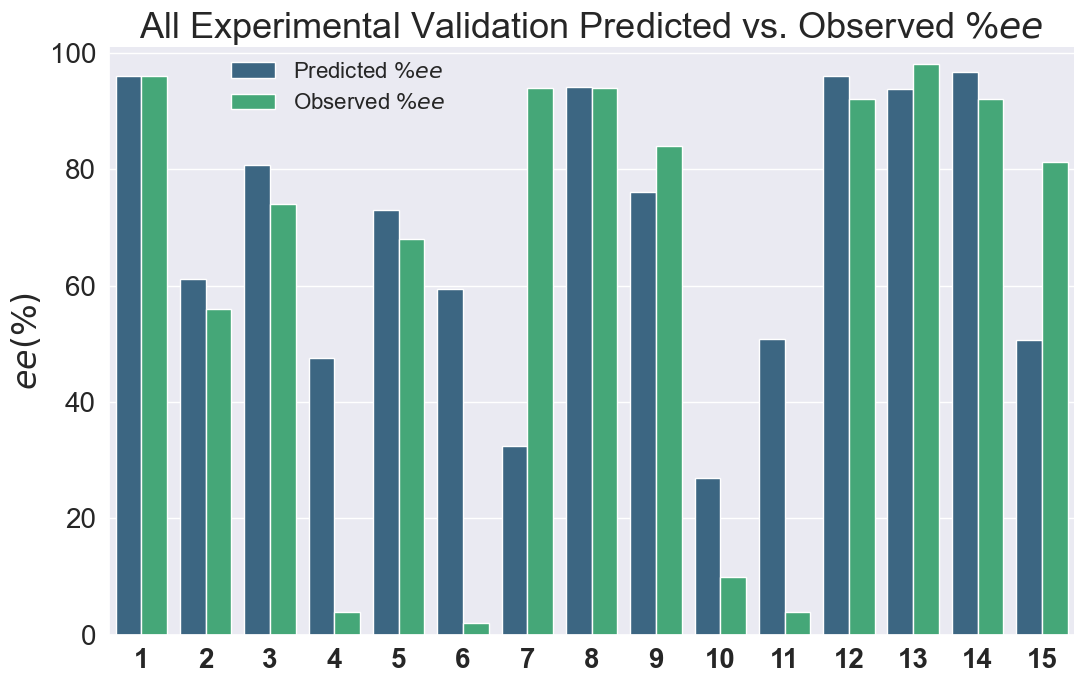

In [17]:
ee = pd.concat(ee_dfs, axis=0)

ee['Order'] = ee['Alkenes'].map(ev_alk_map).astype(int)

ee = ee.sort_values(by='Order')

ee['Alkene'] = ee['Alkenes'].map(ev_alk_map)

ee.to_csv('test.csv')

ee_long_df = plot_full_ee_barplot(
        ee, 
        title=f"All Experimental Validation Predicted vs. Observed $\\%ee$", 
        error_bars=False,
        figsize=(11,7),
        color_palette=custom_palette)